In [ ]:
# (auto-reload changes from imported libraries)
%load_ext autoreload
%autovaload 2

In [ ]:
import pm4py
import pandas as pd

log = pm4py.read_xes("../logs/sepsis/sepsis.xes")
# log = pd.read_csv("../logs/sepsis/sepsis_subset.csv")

In [ ]:
from convert_log import convert_xes_rdf, RdfRepresent
from rdflib import Namespace

Sepsis = Namespace("http://dutch.hospital.nl/sepsis#")

# convert_xes_rdf(log, "../logs/sepsis/sepsis_pred_25.n3", RdfRepresent.LINK_PRED, 250)
# convert_xes_rdf(log, "../logs/sepsis/sepsis_50.n3", RdfRepresent.LINK_PRED, 500)
# convert_xes_rdf(log, "../logs/sepsis/sepsis_pred_all.n3", RdfRepresent.LINK_PRED)
convert_xes_rdf(log, "../logs/sepsis/sepsis_subset.n3", Sepsis, RdfRepresent.LINK_PRED)

In [3]:
import pm4py
import pandas as pd

log = pm4py.read_ocel2("../logs/ocel2/ocel2-p2p.xml")

In [ ]:
from convert_log import convert_ocel2_rdf, RdfRepresent
from rdflib import Namespace

P2P = Namespace("http://ocel2.org/p2p#")

convert_ocel2_rdf(log, "../logs/ocel2/ocel2-p2p-5000.ttl", P2P, 5000)

In [ ]:
from convert_log import filter_traces_graph

filter_traces_graph("logs/ocel2/ocel2-p2p-1000-traces.ttl", "logs/ocel2/ocel2-p2p-filter.ttl", "../logs/ocel2/ocel2-p2p-1000-traces-subset.ttl", True)

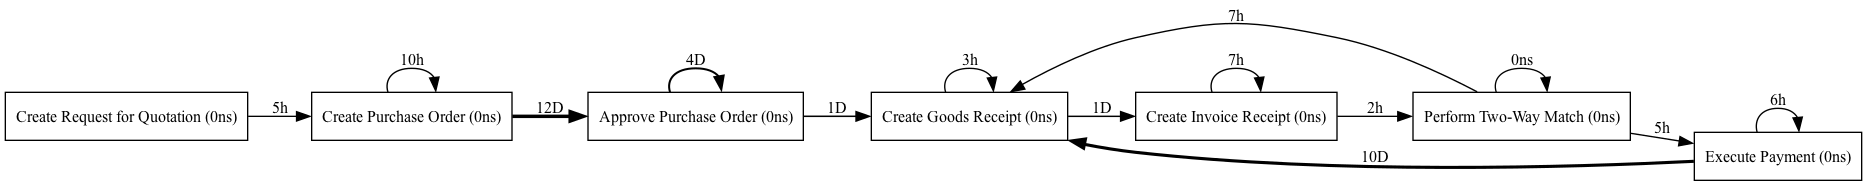

In [47]:
import rdflib
from convert_log import convert_rdf_xes

g = rdflib.Graph()
# g.parse("logs/ocel2/ocel2-p2p-1000-traces.ttl")
# g.parse("logs/ocel2/ocel2-p2p-trace.ttl")
# g.parse("logs/ocel2/ocel2-p2p-traces-complete.ttl")
g.parse("logs/ocel2/ocel2-p2p-1000-traces-subset.ttl")
g.parse("logs/ocel2/ocel2-p2p-1000.ttl")

g_log = convert_rdf_xes(g)

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

dfg = dfg_discovery.apply(g_log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualizer.apply(dfg, log=g_log, variant=dfg_visualizer.Variants.PERFORMANCE)
dfg_visualizer.view(gviz)

## Explore the process log

### Follow object relations & create graph

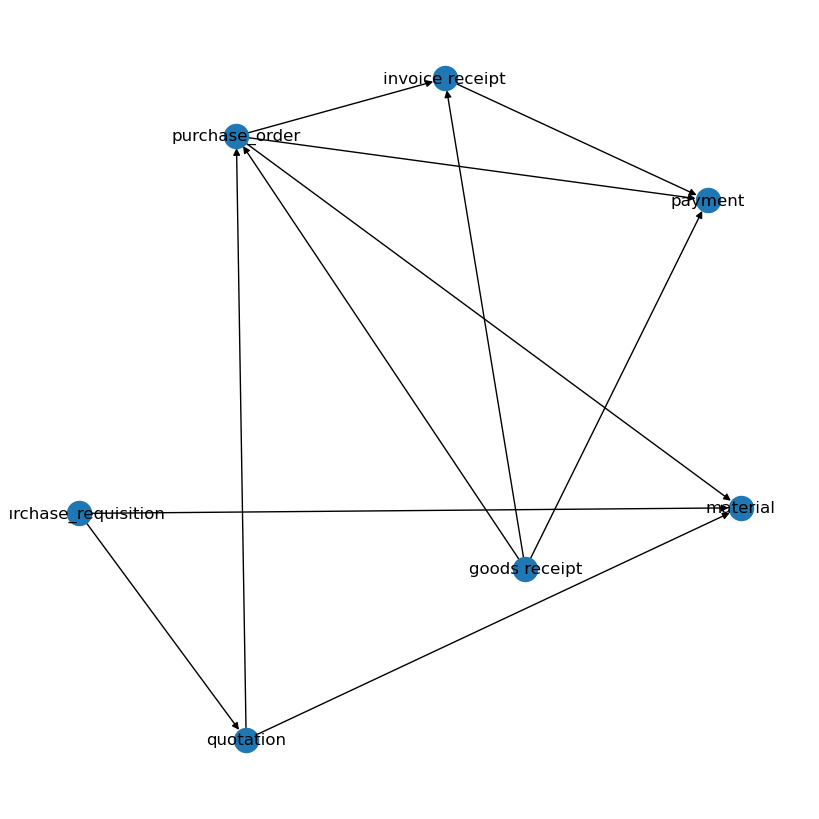

In [96]:
import networkx as nx 
import matplotlib.pyplot as plt 
from itertools import chain

seed = 'purchase_requisition:0:pr_trigger_0'

G = nx.DiGraph(height = "750px",
                width = "100%") 

relations = {}; objects = []
queue = [ seed ]

visited = []
while len(queue) > 0:
    next = queue.pop()
    objects.append(next)
    
    visited.append(next)
    
    result = log.o2o.loc[(log.o2o['ocel:oid']==next),]
    result2 = log.o2o.loc[(log.o2o['ocel:oid_2']==next),]
    
    for _, row in chain(result.iterrows(), result2.iterrows()):
        n1 = row['ocel:oid']; n2 = row['ocel:oid_2']; qual = row['ocel:qualifier']
        n1t = log.objects.loc[log.objects['ocel:oid']==n1,'ocel:type'].head(1).item()
        n2t = log.objects.loc[log.objects['ocel:oid']==n2,'ocel:type'].head(1).item()
        
        # if n1t == 'material' or n2t == 'material':
        #     continue
        
        # rel = (n1, n2)
        rel = (n1t, n2t)
        if rel not in relations:
            relations[rel] = qual
            G.add_edge(rel[0], rel[1])
            
            if n1 not in visited:
                queue.append(n1)
            if n2 not in visited:
                queue.append(n2)

# for _, row in log.relations.loc[log.relations['ocel:oid'].isin(objects),].iterrows():
#     G.add_edge(row['ocel:eid'], row['ocel:oid'])

# print(log.relations.loc[log.relations['ocel:oid'].isin(objects),[ 'ocel:oid', 'ocel:eid' ]])

plt.figure(figsize=(8,8)) 
pos = nx.spring_layout(G, scale=3, k=3)
nx.draw(G, pos, with_labels=True)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=relations)
plt.show() 

# T = nx.minimum_spanning_tree(G.to_undirected())
# print([ e if e in G.edges() else list(reversed(e)) for e in T.edges() ])
# G2 = nx.DiGraph([ e if e in G.edges() else list(reversed(e)) for e in T.edges() ])
# relations2 = { rel:label for rel, label in relations.items() if rel in G2.edges() }

# plt.figure(figsize=(8,8)) 
# pos = nx.spring_layout(G2, scale=3, k=3)
# nx.draw(G2, pos, with_labels=True)
# nx.draw_networkx_edge_labels(G2, pos, edge_labels=relations2)
# plt.show() 


# log.o2o.loc[log.o2o['ocel:oid']=='quotation:0',]
# log.o2o.loc[log.o2o['ocel:oid']=='purchase_order:2',]
# log.o2o.loc[log.o2o['ocel:oid_2']=='payment:2',]

# log.o2o.loc[log.o2o['ocel:oid_2']=='material:1',]

### Misc

In [137]:
def evt_obj_cardin(evt_activ, obj_type):
    evts = log.events.loc[log.events['ocel:activity']==evt_activ, 'ocel:eid']
    objs = log.objects.loc[log.objects['ocel:type']==obj_type, 'ocel:oid']
    relations = log.relations.loc[(log.relations['ocel:eid'].isin(evts))&(log.relations['ocel:oid'].isin(objs)),].sort_values(by='ocel:eid')
    # print(relations)
    counts = relations.groupby('ocel:eid')['ocel:oid'].count()
    return f"{evt_activ} -->{('1' if len(counts[counts > 1])==0 else '*')} {obj_type}"

print(evt_obj_cardin('Create Purchase Order', 'purchase_order'))
print(evt_obj_cardin('Execute Payment', 'payment'))

Create Purchase Order -->1 purchase_order
Execute Payment -->1 payment


In [135]:
def obj_cardin(src_type, tgt_type, src_col='ocel:oid', tgt_col='ocel:oid_2'):
    src_tgt = obj_cardin_one_way(src_type, tgt_type, src_col, tgt_col)
    tgt_src = obj_cardin_one_way(tgt_type, src_type, tgt_col, src_col)
    
    return f"{src_type} {tgt_src}-->{src_tgt} {tgt_type}"

def obj_cardin_one_way(src_type, tgt_type, src_col, tgt_col):
    srcs = log.objects.loc[log.objects['ocel:type']==src_type, 'ocel:oid']
    tgts = log.objects.loc[log.objects['ocel:type']==tgt_type, 'ocel:oid']
    relations = log.o2o.loc[(log.o2o[src_col].isin(srcs))&(log.o2o[tgt_col].isin(tgts)),].sort_values(by='ocel:oid')
    # print(relations)
    counts = relations.groupby(src_col)[tgt_col].count()
    return ('1' if len(counts[counts > 1])==0 else '*')

print(obj_cardin('purchase_requisition', 'quotation'))
print(obj_cardin('quotation', 'purchase_order'))
print(obj_cardin('purchase_order', 'invoice_receipt'))
print(obj_cardin('goods_receipt', 'purchase_order'))
print(obj_cardin('purchase_order', 'payment'))

purchase_requisition 1-->1 quotation
quotation 1-->* purchase_order
purchase_order 1-->1 invoice_receipt
goods_receipt 1-->1 purchase_order
purchase_order *-->1 payment


In [138]:
log.events['ocel:activity'].unique()

<StringArray>
[           'Create Purchase Requisition',
           'Approve Purchase Requisition',
 'Delegate Purchase Requisition Approval',
           'Create Request for Quotation',
                  'Create Purchase Order',
                 'Approve Purchase Order',
                   'Create Goods Receipt',
                 'Create Invoice Receipt',
                  'Perform Two-Way Match',
                        'Execute Payment']
Length: 10, dtype: string

In [85]:
log.objects['ocel:type'].unique()

<StringArray>
[       'goods receipt',      'invoice receipt',             'material',
              'payment',       'purchase_order', 'purchase_requisition',
            'quotation']
Length: 7, dtype: string

In [26]:
log.relations

,ocel:eid,ocel:activity,ocel:timestamp,ocel:oid,ocel:type,ocel:qualifier
20464,event:1,Create Purchase Requisition,2022-04-01 09:26:00+00:00,material:3,material,material
20465,event:1,Create Purchase Requisition,2022-04-01 09:26:00+00:00,material:1,material,material
20466,event:1,Create Purchase Requisition,2022-04-01 09:26:00+00:00,material:0,material,material
20467,event:1,Create Purchase Requisition,2022-04-01 09:26:00+00:00,material:2,material,material
20468,event:1,Create Purchase Requisition,2022-04-01 09:26:00+00:00,purchase_requisition:0:pr_trigger_0,purchase_requisition,purchase_requisition
...,...,...,...,...,...,...
32040,event:29341,Execute Payment,2024-10-31 20:28:00+00:00,goods receipt:1938,goods receipt,goods receipt
32041,event:29341,Execute Payment,2024-10-31 20:28:00+00:00,goods receipt:1940,goods receipt,goods receipt
32042,event:29341,Execute Payment,2024-10-31 20:28:00+00:00,goods receipt:1939,goods receipt,goods receipt
32043,event:29341,Execute Payment,2024-10-31 20:28:00+00:00,invoice receipt:1940,invoice receipt,invoice receipt


In [ ]:
log.o2o

In [ ]:
log.e2e

In [ ]:
log.object_changes

In [ ]:
log.object_changes['ocel:type'].unique()

In [ ]:
log.object_changes['ocel:field'].unique()

In [ ]:
log.object_changes.loc[log.object_changes['ocel:type']=='purchase_order','ocel:field'].unique()

In [ ]:
for col in log.object_changes.columns:
    num_values = len(log.object_changes.loc[(log.object_changes[col].notna())&(log.object_changes['ocel:type']=='payment'),])
    if num_values > 0:
        print(col, num_values)

In [ ]:
log.object_changes.loc[log.object_changes['ocel:type']=='payment','Amount (DMBTR)'].unique()

In [ ]:
log.object_changes.loc[(log.object_changes['ocel:type']=='quotation')&(log.object_changes['ocel:field']=='new_value')&(log.object_changes['new_value']!='None'),'new_value']

### Double-check query results

In [ ]:
evt_objs = log.relations.loc[log.relations['ocel:eid']=='event:985','ocel:oid']
evt_objs

In [ ]:
obj_evts = log.relations.loc[log.relations['ocel:oid'].isin(evt_objs), 'ocel:eid']
obj_evts

In [ ]:
log.events.loc[log.events['ocel:eid'].isin(obj_evts),].sort_values(by='ocel:timestamp', ascending=False)